# BLU11 - Learning Notebook - Part 1 of 2 - Collaborative Filtering

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from numpy.linalg import norm
from scipy.sparse import csr_matrix, save_npz

from sklearn.metrics.pairwise import cosine_similarity

# Welcome to personalized recommendations

Imagine that a company selling video games online (e.g., Steam, Apple Arcade) hires you to help scale recommendations.

At the beginning of the company, there were a handful of players and games.

Early customers were somewhat similar, given that most come from word-of-mouth, and people in the real world tend to share advice with friends and family with similar tastes.

Games were not incredibly diverse themselves, as they were highly curated by the company, according to pre-defined criteria, such as genre or storytelling.

Hence, recommendations were a hybrid of non-personalized recommenders (given that users were more or less alike), such as best-sellers lists, and manual suggestions provided over the phone or by email by the company.

In short, for as long as there were games available that matched the typical players, all was good.

Except that, to grow the business, the company wants to expand to new customer segments and diversify its games offering to grab a more significant proportion of the market.

There is, nonetheless, a challenge: how can we efficiently match players to games, when faced with a variety of alternatives? 

By the way, welcome to the job! :)

# About the data

Once you arrive at the new job, this is what you have to work with:
* The `hours_played.csv` is a table of hours played per user per game
* The `video_games.csv` is a table containing the video games
* The `metadata.json` is a file containing some necessary video game metadata.

The metadata looks ugly 💩 , and we decide to ignore, for now. So what do we have, effectively?

## Hours played

The `hours_played.csv` is the record of the **number of hours played per player per game**:
* Each row is a **game purchase**, identified by the corresponding `UserID` and `VideoGameID` (game)
* `HoursPlayed == 1` means that the user bought the game but **played it for less than one hour** (in fact, `HoursPlayed <= 1`)
* The column `HoursPlayed` refers to the **total time played** by the user for the game, in hours. 

In [2]:
hours_played = pd.read_csv(os.path.join('data', 'hours_played.csv'))

The data is in long-format, where each row is an observation, the number of hours played, for a user-item pair, $(u, i) \in (U, I)$. 

Most times, you learn, this is the first input of a recommender.

In [3]:
hours_played.head()

,UserID,VideoGameID,HoursPlayed
0,0,227,5.9
1,0,852,145.0
2,0,978,1.0
3,0,984,1.0
4,0,1131,1.0


This table is the **memory of the recommender system** as it records the history of the entire community.

Since the engineering team kindly pre-processed the data, you can assume that:
* There is **a single entry or row per user per game**
* **User IDs are sequential integers**, ranging from 0 to 12392 (both inclusive)
* **Video game IDs (i.e., Item IDs) are also sequential integers**, ranging from 0 to 5154 (both inclusive).

Typically (in a Hackathon, for example 🤓), none of these can be safely assumed and should be ensured by the Data Scientist.

## Video games

The `video_games.csv` is an auxiliary table that **maps the video game IDs to the video game name**.

In [4]:
video_games = pd.read_csv(os.path.join('data', 'video_games.csv'), index_col='VideoGameID')

In [5]:
video_games.head()

,VideoGameName
VideoGameID,
0,007 Legends
1,0RBITALIS
2,1... 2... 3... KICK IT! (Drop That Beat Like a...
3,10 Second Ninja
4,"10,000,000"


We use this table to learn which `VideoGameName` corresponds to a `VideoGameID` so that **it makes sense for the final user**.

# Building the ratings

Assuming **hours played as a proxy for preference**, i.e., most played games are the most interesting, we want to build a ratings matrix, $\boldsymbol{R}$.

For a community of $m$ users and $n$ items, the ratings are a $m$ by $n$ matrix with the users, $U$, in the rows and the items, $I$, in the columns:

$$ R = \begin{bmatrix}r_{0, 0} & r_{0, 1} & \dots & r_{0, n}\\ r_{1, 0} & r_{1, 1} & \dots & r_{1, n}\\ \dots & \dots & \dots & \dots \\ r_{m, 0} & r_{m, 1} & \dots & r_{m, n}\end{bmatrix}$$

In our case, **the users are the players, and the items are the games**, and $m$ and $n$ are equal to 128,803 users and 5,155 items.

Ratings correspond to hours played and, thus, can only be positive real numbers, $r_{u, i} \in \mathbb{R}_{>0}$.

We can use `df.pivot` ([read the docs](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html)) to convert data from **long- to wide-form** and **create a column for each `VideoGameID`**.

In [6]:
(hours_played.pivot(index='UserID', columns='VideoGameID', values='HoursPlayed')
             .head(n=3))

VideoGameID,0,1,2,3,4,5,6,7,8,9,...,5145,5146,5147,5148,5149,5150,5151,5152,5153,5154
UserID,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
(hours_played.pivot(index='UserID', columns='VideoGameID', values='HoursPlayed')
             .tail(n=3))

VideoGameID,0,1,2,3,4,5,6,7,8,9,...,5145,5146,5147,5148,5149,5150,5151,5152,5153,5154
UserID,,,,,,,,,,,,,,,,,,,,,
12390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We represent the ratings matrix as sparse because **most ratings are unknown to us**, or else we don't need a fancy recommender.

We use Pandas to get the data to the right shape (users as rows, items as columns, and ratings as values) and then **convert the result into a sparse matrix**.

In [8]:
def make_ratings(hours_played):
    return csr_matrix(hours_played.pivot(index='UserID', 
                                         columns='VideoGameID', 
                                         values='HoursPlayed')
                                  # Good practice when setting the index.
                                  .sort_index()
                                  # Sparse matrices don't assume NaN value as zeros.
                                  .fillna(0)) 


R = make_ratings(hours_played)

We were able  **to transform the community history into a proper ratings matrix**, and we are one step closer to our goal.

We **persist the ratings matrix**, as it can be useful in the future.

In [9]:
save_npz(os.path.join('data', 'ratings_matrix.npz'), R)

# Collaborative filtering

Now that we have the data ready, it's time for some whiteboarding. 

How can we go about using the ratings matrix to provide personalized recommendations? 🤔

Logically, you work under the assumption that what is true for word-of-mouth holds valid for personalized recommenders: **that people value more highly the opinions of other people that are (or are perceived to be) most like them**.

## Collaborative recommendations

You hypothesize that (1) if you can identify similar users, **Player A** and **Player B**, then (2) **you can recommend Player A a game that he doesn't own, but is well-liked by Player B** and vice-versa. You take a snapshot of the whiteboard:

![user-user-collaborative-filtering](media/user-user-collaborative-filtering.png)
*Image 1: Recommending unrated items favored by similar users.*

An idea for similarities **is to identify users that play the same games** (e.g., Players A and B both play Game 1).

You take a step back to realize something new: **Game 1 is connected to both Games 2 and 3**, by Users 1 and 2, respectively. 

**When the same user plays two games, they must have something in common**. Thus, you gather your thoughts:
* The most games users have in common, the more similar they should be
* The most users games have in common, the more similar they should be. 

This approach is collaborative, as **the history of the rest of the community is used to provide personalized recommendations for the user**.

## Defining neighborhoods of users or items

Finally, you take your idea one step further, inspired by the $k$-nearest neighbor ($k$-NN) algorithm for regression.

Assuming we can calculate similarities between users or items, then we define neighborhoods: 
* $N^k_i(u)$, containignt **the $k$ the most similar neighbors of user $u$** that **rated the item $i$**
* $N^k_u(i)$, with **the $k$ most similar neighbors of item $i$** that were **rated by the user $u$**.

The maximum value of $k$ is the length of the set of all users that rated the item, $U_i$, or of all ratings by the user, $I_u$, respectively.

## Predicting ratings based on the $k$-nearest neighbors

The easiest way to predict an unknown rating, $r_{ui}$, would be **to average the ratings of the neighbors**. 

For example, using the neighborhood of the user $u$ for item $i$ (**user-based** recommendation), $N^k_i(u)$:

$$\hat{r}_{ui} = \frac{\sum_{v \in N^k_i(u)} r_{vi}}{k}$$

But you realize you can do better: what if there are neighbors that are very similar and some that are not similar at all? The most similar neighbors should have more weight to **emulate the word-of-mouth behavior** we are trying to model. You decide to use a weighted average, instead:

$$\hat{r}_{ui} = \frac{\sum_{v \in N^k_i(u)} sim(u, v)  \cdot r_{vi}}{\sum_{v \in N^k_i(u)} |sim(u, v)|}$$

The formulation uses the **absolute value of the similarities, as to accommodate negative similarities**.

Alternatively, using the neighborhood of the item $i$ for user $u$, $N^k_u(i)$:

$$\hat{r}_{ui} = \frac{\sum_{j \in N^k_u(i)} sim(i, j)  \cdot r_{uj}}{\sum_{j \in N^k_u(i)} |sim(i, j)|}$$

The **item-based** prediction of $r_{ui}$ is, therefore, **the weighted average of the ratings by user $u$ to items in the $k$ nearest neighbors of $i$**.

Collaborative filtering relies on computing **predicted ratings based on the average of the $k$ neighbors, weighted by the similarity**.

It can be **user-user**, when we are using the neighborhood of $u$, $N^k_i(u)$, or **item-item**, when we are using the neighborhood of $i$, $N^k_u(i)$.

Enough of the whiteboard, it's implementation time. 💪

# Computing the similarities

The problem, therefore, becomes: **how do we go about computing similarities**? 

Fortunately, we already have in our toolkit an appropriate tool to solve this problem. Let's start with a few examples to get the requirements right.

For the sake of conciseness, **we focus on similarities between users**, for now.

## Users with identical ratings

Imagine the simplest case in which we have two players, **Player A** and **Player B**, and two games, **Game 0** and **Game 1**.

The most similar users would play the same games for the same amount of time.

In [10]:
example_1 = pd.DataFrame.from_dict({'A': [1000, 1000], 'B': [1000, 1000]})
example_1

,A,B
0,1000,1000
1,1000,1000


We project the user-vectors, which are precisely the same, in **the two-dimensional space formed by both games**.

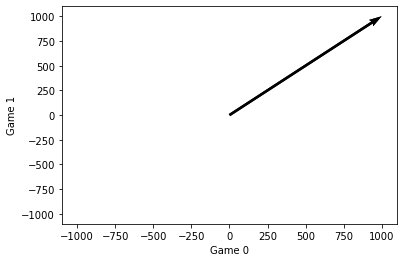

In [11]:
def plot_vectors(vectors):
    X, Y, U, V = zip(*vectors)
    plt.figure()
    ax = plt.gca()
    ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1)
    ax.set_xlim([-1100, 1100])
    ax.set_ylim([-1100, 1100])
    ax.set_xlabel('Game 0')
    ax.set_ylabel('Game 1')
    plt.draw()
    plt.show()

    
vectors_1 = np.array([[0, 0, 1000, 1000], [0, 0, 1000, 1000]])
plot_vectors(vectors_1)

From the representation, we understand that the users are **indifferent between both games**, i.e., like them equally, as illustrated by the 45º line.

If we are to use a similarity metric, **the similarity between these vectors must be high**.

## Does scale matter?

Finally, imagine two players that play the same games, but one player (Player A) plays relatively more hours.

In [12]:
example_2 = pd.DataFrame.from_dict({'A': [1000, 1000], 'B': [500, 500]})
example_2

,A,B
0,1000,500
1,1000,500


We understand these vectors are **still collinear** and **have the same direction**, but have different magnitudes.

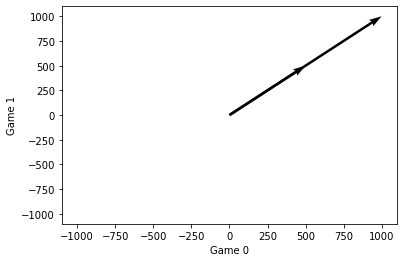

In [13]:
vectors_2 = np.array([[0, 0, 1000, 1000], [0, 0, 500, 500]])
plot_vectors(vectors_2)

We are interested in relative preferences, i.e., how items are valued relative to each other, and, thus, **we decide to ignore the scale**. 

This example is similar to the first one, and **Games 0 and 1 are valued equally by both users**.

Henceforth, **the similarity between the vectors should be high still** (and as high as in the last example). 

Note that distance metrics that consider the magnitude of the vectors, such as the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) or the [dot product](https://en.wikipedia.org/wiki/Dot_product), violate this principle.

## Users with exclusive ratings

Now, take the case in which users play exclusively different games for the same amount of time.

In [14]:
example_3 = pd.DataFrame.from_dict({'A': [1000, 0], 'B': [0, 1000]})
example_3

,A,B
0,1000,0
1,0,1000


These are users with different tastes. Again, **we project the users into the space of the games**.

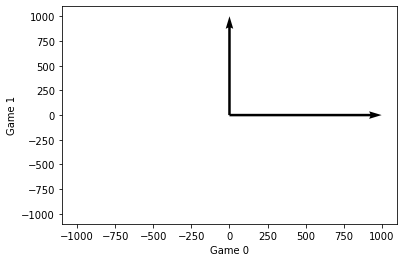

In [15]:
vectors_3 = np.array([[0, 0, 1000, 0], [0, 0, 0, 1000]])
plot_vectors(vectors_3)

We grasp, intuitively, that the preferences are exclusive and that **the respective user vectors are orthogonal in space**. *There is no similarity*.

It means that the users have nothing in common and, thus, **any similarity metric should be equal to zero** in this case.

## What about opposite ratings?

Consider now that the company is considering the creation of a **negative feedback signal**. How could similarities account for this?

Imagine that negative feedback (e.g., a dislike or downvote button) would be stored with the value -1000, as follows.

In [16]:
example_4 = pd.DataFrame.from_dict({'A': [1000, 0], 'B': [-1000, 0]})
example_4

,A,B
0,1000,-1000
1,0,0


**The Players A and B are inversely affected by Game 0**, whereas Player A likes it (positive preference), the Player B doesn't (negative).

What can we conclude by inspecting the projections?

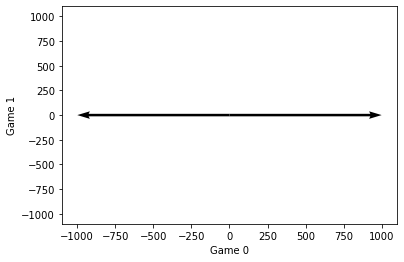

In [17]:
vectors_4 = np.array([[0, 0, 1000, 0], [0, 0, -1000, 0]])
plot_vectors(vectors_4)

The user vectors, in this case, **are collinear but have opposite directions** and a negative similarity (i.e., **they are the opposite**). Thus, any similarity metric to fit our problem needs to be negative in this case.

Again, we are already familiar with such a similarity metric. So **you decide to use the cosine similarity**.

## Cosine similarity

The cosine similarity, which **measures differences in orientation by using the cosine of the angle between two vectors**, fits our problem:

$$sim(u, v) = cos(\theta) = \frac{u \cdot v}{||u||||v||} = \frac{\sum_{i \in I_{uv}} u_i v_i}{\sqrt{\sum_{i \in I_{u}} u_i^2} \sqrt{\sum_{i \in I_{v}} v_i^2}}$$

Where $I_{uv}$ stands for the **set of items rated by both users**, and $I_{u}$ and $I_{v}$ for the **sets of items rates by $u$ and $v$**, respectively.

The cosine distance is **the normalized dot product** (and therefore unaffected by scale) and the resulting similarity ranges from:
* −1 meaning exactly opposite (example 4) and 1 precisely the same (examples 1 and 2)
* 0 indicating orthogonality or decorrelation (example 3)
* In-between values indicate intermediate similarity.

Alternatively, the cosine similarity **can be formulated as distance metric** as:

$$dist(u, v) = 1- sim(u, v)$$

In this case, it works the opposite way: the higher the distance, the more different.

In [18]:
def similarity(u, v):
    return round(np.dot(u, v) / (norm(u) * norm(v)), 2)


similarity(example_1.A, example_1.B)

1.0

In [19]:
similarity(example_2.A, example_2.B)

1.0

In [20]:
similarity(example_3.A, example_3.B)

0.0

In [21]:
similarity(example_4.A, example_4.B)

-1.0

Alternatively, we can compute similarities for pairs of items as follows:

$$sim(i, j) = cos(\theta) = \frac{i \cdot j}{||i||||j||} = \frac{\sum_{u \in U_{ij}} i_u j_u}{\sqrt{\sum_{u \in U_i} i_u^2} \sqrt{\sum_{u \in U_j}  j_u^2}}$$

$U_{ij}$ is **the set of users that rates both items**, while $U_i$ and $U_j$ are the **users that rated $i$ and $u$**, respectively.

# Computing similarities

Implementation time: the `cosine_similarity` from `sklearn.metrics.pairwise` computes the cosine between samples in $A$ and $B$ ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html)):

$$sim(A, B) = \frac{A \cdot B}{||A||||B||}$$ 

If $A$ is a $m \times n$ matrix and $B$ a $n \times k$ matrix, **the result will be a $m \times k$ containing the cosine distance between all samples**.

Doing this, we can compute the cosine similarity between all samples at once, in a vectorized and efficient way.

## Between users

In our case, we obtain, $S_u$, a $U \times U$, containing the cosine similarity between all users, as:

$$S_U = \frac{R \cdot R^T}{||R||||R^T||}$$

$R$ and $R^T$ are $U \times I$ and $I \times U$ matrices, respectively. $S_u$ contains the cosine distance for all pairs $(u, v) \in U \times U$:

$$S_U = \begin{bmatrix}1 & cos(u_0, v_1) & \dots & cos(u_0, v_m) \\ cos(u_1, v_0) & 1 & \dots & cos(u_1, v_m) \\ \dots  & \dots & 1 & \dots \\ cos(u_m, v_0) & cos(u_m, v_1) & \dots & 1\end{bmatrix}$$

The result is a triangular matrix, a square matrix **with repeated entries above of below the main diagonal**.

In [22]:
def make_user_similarities(R):
    return cosine_similarity(R, dense_output=False)


user_similarities = make_user_similarities(R)

## Between items

The items matrix, $S_i$, stores the consine similarity between all pairs of items:

$$S_I = \frac{R^T \cdot R}{||R^T||||R||}$$

The result is a $I \times I$ triangular matrix with the cosine distance between all pairs $(i, j) \in I \times I$:

$$S_I = \begin{bmatrix}1 & cos(i_0, j_1) & \dots & cos(i_0, j_n) \\ cos(i_1, j_0) & 1 & \dots & cos(i_1, j_n) \\ \dots  & \dots & \dots & \dots \\ cos(i_n, j_0) & cos(i_n, j_1) & \dots & 1\end{bmatrix}$$

In [23]:
def make_item_similarities(R):
    return cosine_similarity(R.T, dense_output=False)


item_similarities = make_item_similarities(R)

# Making predictions

## Based on user-similarities, $S_u$

For the sake of simplicity, instead of the $k$ most similar, consider that we use all available neighbors,$N_i(u)$, for prediction.

$$\hat{r}_{ui} = \frac{\sum_{v \in N_i(u)} sim(u, v)  \cdot r_{vi}}{\sum_{v \in N_i(u)} |sim(u, v)|}$$

In this particular case, $N_i(u)$ contains all the users that rated item $i$. Again, we use vectorization to compute all predictions at once.

In [24]:
def make_user_predictions(S, R):
    
    weighted_sum = np.dot(S, R)
    
    # We use the absolute value to support negative similarities.
    # In this particular example there are none.
    sum_of_weights = np.abs(S).sum(axis=1)
    
    preds = weighted_sum / sum_of_weights
    
    # Exclude previously rated items.
    preds[R.nonzero()] = 0
    
    return csr_matrix(preds)
 

user_preds = make_user_predictions(user_similarities, R)

In [46]:
print(user_preds)

  (0, 1)	0.0006544929229685474
  (0, 2)	0.012809645892423381
  (0, 3)	0.005443633770613753
  (0, 4)	0.0019110216962606654
  (0, 5)	0.002685263329379299
  (0, 6)	0.00018049236111622802
  (0, 7)	0.001893796120454366
  (0, 8)	0.001292791778557575
  (0, 9)	0.0009200213886105356
  (0, 10)	0.001990785388947909
  (0, 12)	0.0010334475914411916
  (0, 13)	0.0009044006698212594
  (0, 14)	0.0005662266363695838
  (0, 15)	0.0009059626181913343
  (0, 16)	4.376855279445677e-05
  (0, 17)	0.0014472100392712987
  (0, 18)	0.0004402324365763852
  (0, 19)	0.0003154218526273414
  (0, 20)	0.00016105377706775308
  (0, 21)	0.00023606666888878632
  (0, 22)	1.248671841323318e-05
  (0, 23)	0.00010969428023562313
  (0, 25)	0.014616271090772256
  (0, 26)	0.001056180021074424
  (0, 27)	0.0020053619692308564
  :	:
  (12392, 5119)	5.676595415439185e-07
  (12392, 5120)	9.756534381717324e-06
  (12392, 5121)	0.00028311299774862317
  (12392, 5123)	0.0006229568882395765
  (12392, 5124)	4.5045996512806375e-05
  (12392, 5125)

Please note that, despite our efforts, we were **unable to predict many ratings**.

Meet the **the cold-start problem**. Notably, we won't be able to make predictions **for users that don't have items in common with other users**.

In that case, $\forall v \in U\setminus{u}, I_{uv} = \emptyset$, then **there are no available neighbors and, thus, no prediction can be made**, i.e., $N(u) = \emptyset$.

Additionally, the set of neighbors that rated item $i$ is a subset of all neighbors, $N_i(u) \subseteq N(u)$. So, in order to make a prediction for user $u$, we need at least an user $v \in U$ with items in common with user $u$, $I_{uv} \neq \emptyset$, that rated item $i$.

In [26]:
def sparsity(matrix):
    return 1 - matrix.nnz / (matrix.shape[0] * matrix.shape[1])


sparsity(user_preds)

0.2291358744724874

Above, **we use `.nnz` to return the count of non-zero stored values** ([docs](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.nnz.html)). The sparsity score gives us **the percentage of ratings that we couldn't predict**.

23% of missing predictions is not so bad, especially when we compare the sparsity of the predicted ratings vs the initial ratings (we'll leave this one for you to check). 

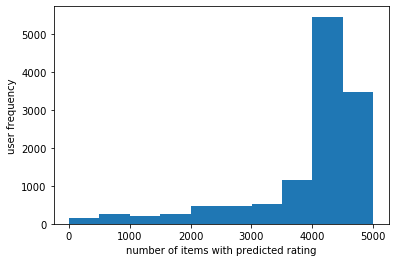

In [27]:
plt.hist(user_preds.getnnz(axis=1))
plt.xlabel('number of items with predicted rating')
plt.ylabel('user frequency');

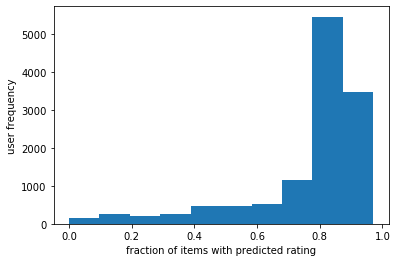

In [28]:
# same plot but with fractions instead of absolute counts
plt.hist(user_preds.getnnz(axis=1) / user_preds.shape[1])
plt.xlabel('fraction of items with predicted rating')
plt.ylabel('user frequency');

From the plot above, we understand that **while most users have a significant number of predicted item ratings, some don't (including users with zero predicted item ratings, for which we are unable to make predictions)**.

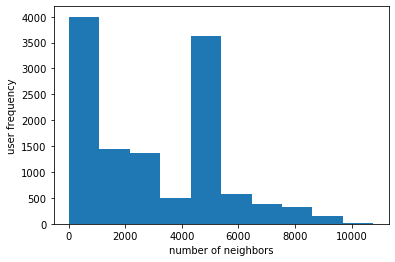

In [29]:
# The -1 is because the user_similarities matrix has 1 on the main diagonal,
# which represents self-similarity, that we don't want to consider
user_total_neighbors = user_similarities.getnnz(axis=1) - 1
plt.hist(user_total_neighbors)
plt.xlabel('number of neighbors')
plt.ylabel('user frequency');

From the plot above, we also realize that **a significant amount of users don't have many neighbors** (i.e., users with at least one item in common). The plot below shows the a zoomed-in on the the users with little neighbors.

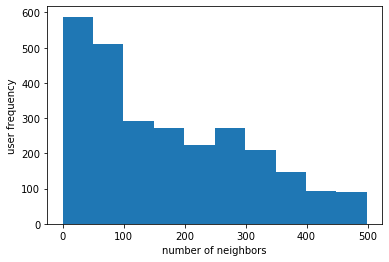

In [30]:
plt.hist(user_total_neighbors[user_total_neighbors < 500])
plt.xlabel('number of neighbors')
plt.ylabel('user frequency');

In [31]:
user_total_neighbors[user_total_neighbors < 500].shape[0]

2701

There are 2701 users with **less than 500 neighbors**.

In [32]:
(user_total_neighbors == 0).sum()

19

**But only 19 users don't have neighbors, which is close to none!**

For as long as one neighbor has **rated the item whose rating we are predicting**, we can make a prediction. Hence, **the relatively low sparsity score of the predictions matrix**. But **we can't assure that the prediction is any good**. 

Imagine the extreme case in which a user has a single neighbor and that neighbor is not similar at all: what will we predict? Well, we'll predict that the user won't like anything that the neighbor has bought (these items will have a bad predicted rating), but we don't know how to recommend anything else, because all the other items will have a neutral predicted rating!

Also, there's the trade-off: if we limit the predictions to users with over **a minimum threshold of neighbors**, possibly even accounting for minimum similarity, **the sparsity of the predictions matrix increases**, and we need to be addressed it, somehow. (Non-personalized recommendations, perhaps.)

The cold-start problem is a **major limitation of collaborative-filtering**, that we explore shortly.

## Based on item-similarities, $S_i$

Analogously, we can use $S_i$ to make predictions based on all available neighbors, $N_u(i)$:

$$\hat{r}_{ui} = \frac{\sum_{j \in N_u(i)} sim(i, j)  \cdot r_{uj}}{\sum_{j \in N_u(i)} |sim(i, j)|}$$

Again, the existence of a neighborhood of item $i$ for user $u$, $N_u(i)$, depends on having **at least an item $j \in I$ with users in common with $i$, also rated by $u$**. 

In [33]:
def make_item_predictions(S, R):
    
    weighted_sum = np.dot(R, S)
    
    # We use the absolute value to support negative similarities.
    # In this particular example there are none.
    sum_of_weights = np.abs(S).sum(axis=0)
    
    preds = weighted_sum / sum_of_weights
    
    # Exclude previously rated items.
    preds[R.nonzero()] = 0
    
    return csr_matrix(preds)

 
item_preds = make_item_predictions(item_similarities, R)
sparsity(item_preds)

0.2291358744724874

Again, we compute the **sparsity score**, which we realize to be the same. You can try it for yourself, **the histograms above for the matrix of predictions also stay the same**.

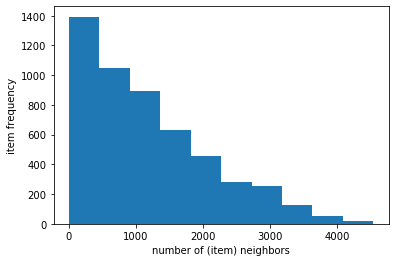

In [34]:
plt.hist(item_similarities.getnnz(axis=1))
plt.xlabel('number of (item) neighbors')
plt.ylabel('item frequency');

The histogram above also shows us that **the distribution of the number of neighbors is quite skewed to the left**, i.e., there are still small neighborhoods.

So, item-based recommendations **don't help us in dealing with the cold-start problem**.

Item-based recommendations, empirically, are said to be **more stable than user preferences**. It means that we don't have to recompute them as often.
As an intuition for this, you can think that usually we have more interactions at the product level than at the user level: while an item will be rated / bought thousands of times, a user will only rate / buy maybe hundreds of products. So the item similarities will tend to be more reliable and change less when new interactions are added.

# Filtering

Now that we have the predictions, the last step is to **filter the items** to recommend the most promising ones.

## Best-item

A typical task is to recommend the best item, i.e., **the item with the highest predicted rating**.

We can use `argmax` ([docs](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html)) on our matrix of predictions to retrieve the index of the item with the maximum rating.

In [35]:
def get_best_item(pred):
    return np.array(pred.argmax(axis=1))


get_best_item(user_preds)

array([[ 981],
       [1336],
       [4257],
       ...,
       [ 981],
       [ 981],
       [ 981]])

In [36]:
get_best_item(item_preds)

array([[4723],
       [2521],
       [5117],
       ...,
       [2328],
       [1539],
       [1539]])

The result, in both cases, is **a column-vector containing the best item for each user**.

Finally, we can use the `video_games` table to retrieve the name of the game.

In [37]:
video_games.loc[981]

VideoGameName    Counter-Strike Global Offensive
Name: 981, dtype: object

In [38]:
video_games.loc[1336]

VideoGameName    Dota 2
Name: 1336, dtype: object

In [39]:
video_games.loc[4257]

VideoGameName    Team Fortress 2
Name: 4257, dtype: object

## Top-N

Perhaps the most typical task, however, is to recommend a top-$N$ list to the user, i.e., **the $N$ items with the best ratings**. 

To do this, we can use `argsort` ([docs](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html)).

In [40]:
def get_top_n(pred, n):
    pred_ = np.negative(pred).toarray()
    return pred_.argsort()[:, :n]


get_top_n(user_preds, 5)

array([[ 981, 4364, 3825, 2475, 1894],
       [1336, 4257,  979, 4364, 1894],
       [4257, 1336,  981, 3825, 1679],
       ...,
       [ 981, 4257, 1336, 4788, 4364],
       [ 981, 4257,  978,  984, 4364],
       [ 981, 4257,  978,  984, 4364]], dtype=int64)

In [41]:
get_top_n(item_preds, 5)

array([[4723, 4874, 3536, 3161,  839],
       [2521, 4999, 3351, 2411, 4085],
       [5117,  469, 1486, 3536, 3201],
       ...,
       [2328, 5144, 5113, 3421, 1988],
       [1539, 1337,  843, 2420, 3558],
       [1539, 1337,  843, 2420, 3558]], dtype=int64)

Again, we can use `video_games` as a lookup table.

In [42]:
video_games.loc[4364]

VideoGameName    The Elder Scrolls V Skyrim
Name: 4364, dtype: object

In [43]:
video_games.loc[3825]

VideoGameName    Sid Meier's Civilization V
Name: 3825, dtype: object

In [44]:
video_games.loc[2475]

VideoGameName    Left 4 Dead 2
Name: 2475, dtype: object

In [45]:
video_games.loc[839]

VideoGameName    Chris Sawyer's Locomotion
Name: 839, dtype: object

In case you're wondering, [Locomotion is the "spiritual successor to Transport Tycoon"](https://en.wikipedia.org/wiki/Chris_Sawyer's_Locomotion), according to the author. 🤯

Back to the **cold-start problem**, now.

# Cold-start problem

Cold-start means that **there is a minimum critical mass of user and items connected through ratings that are required** for collaborative filtering to work.

Intuitively, this makes much sense.

**The more ratings, the better and more complete the similarities** and **the more accurate the predictions**, mainly when many users are rating many items, i.e., a big community.

Also, even in the significant communities, **new users always face the cold-start problem**, as either:
* There is not enough information to identify similar users, because the neighborhood $N(u)$ is inexistent at first and then small
* There are not enough ratings from the user to compute predictions based on item similarities.

The same applies to **new items**.

Hence, the need for techniques that are more robust to this problem, if we want to have (1) **more complete** and (2) **better predictions**.